# Analisis Basico de la Constitucion

La Constitución se compone de un Preámbulo y 13 Títulos, 380 artículos y 67 artículos transitorios,

Cada titulo tiene os titulos son:

I) De los principios fundamentales; 

II) De los derechos, las garantías y los deberes; 

III) De los habitantes y del territorio; 

IV) De la participación democrática y los partidos políticos; 

V) De la organización del Estado; 

VI) De la rama legislativa; 

VII) De la rama ejecutiva; 

VIII) De la rama judicial; 

IX) De las elecciones y la organización electoral; 

X) De los organismos de control; 

XI) De la organización territorial; 

XII) Del régimen económico y de la Hacienda Pública; XIII) De la reforma de la Constitución.

In [ ]:
import PyPDF2


# Option 1: Using PyPDF2
def extract_with_pypdf2(pdf_path):
    with open(pdf_path, 'rb') as file:
        reader = PyPDF2.PdfReader(file)
        text = ""
        for page in reader.pages:
            text += page.extract_text()
    return text


# Choose the better extraction based on your PDF quality
raw_text = extract_with_pypdf2("COLOMBIA-Constitucion.pdf")
articulos_no_transitorios = raw_text.split("DISPOSICIONES TRANSITORIAS")[0]
articulos_transitorias = raw_text.split("DISPOSICIONES TRANSITORIAS")[1]

In [19]:
import re
import pandas as pd
import os


def parse_constitution(text):
    """Extrae capítulos, títulos y artículos de la Constitución."""
    # Patrones para identificar elementos estructurales
    titulo_pattern = r"TITULO\s+([IVX]+)(?:\s*\n|\s+)(.*?)(?=\n|$)"
    capitulo_pattern = r"CAPITULO\s+(\d+)(?:\s*\n|\s+)(.*?)(?=\n|$)"
    articulo_pattern = r"Artículo\s+(\d+)\.(?:\s*\n|\s+)(.*?)(?=Artículo\s+\d+\.|\nTITULO\s+[IVX]+|\nCAPITULO\s+\d+|$)"
    
    # Extraer títulos
    titulos = []
    for match in re.finditer(titulo_pattern, text, re.DOTALL):
        titulo_num = match.group(1)
        titulo_name = match.group(2).strip()
        start_pos = match.start()
        titulos.append({
            'tipo': 'TITULO',
            'numero': titulo_num,
            'nombre': titulo_name,
            'posicion': start_pos
        })
    
    # Extraer capítulos
    capitulos = []
    for match in re.finditer(capitulo_pattern, text, re.DOTALL):
        capitulo_num = match.group(1)
        capitulo_name = match.group(2).strip()
        start_pos = match.start()
        capitulos.append({
            'tipo': 'CAPITULO',
            'numero': capitulo_num,
            'nombre': capitulo_name,
            'posicion': start_pos
        })
    
    # Extraer artículos
    articulos = []
    for match in re.finditer(articulo_pattern, text, re.DOTALL):
        articulo_num = match.group(1)
        articulo_content = match.group(2).strip()
        articulo_content = clean_text(articulo_content)
        start_pos = match.start()
        articulos.append({
            'tipo': 'ARTICULO',
            'numero': articulo_num,
            'contenido': articulo_content,
            'posicion': start_pos
        })
    
    # Combinar y ordenar todos los elementos por posición
    elementos = titulos + capitulos + articulos
    elementos.sort(key=lambda x: x['posicion'])
    
    # Crear estructura jerárquica
    estructura = []
    titulo_actual = None
    capitulo_actual = None
    
    for elemento in elementos:
        if elemento['tipo'] == 'TITULO':
            titulo_actual = {
                'numero': elemento['numero'],
                'nombre': elemento['nombre'],
                'capitulos': []
            }
            capitulo_actual = None
            estructura.append(titulo_actual)
        
        elif elemento['tipo'] == 'CAPITULO':
            capitulo_actual = {
                'numero': elemento['numero'],
                'nombre': elemento['nombre'],
                'articulos': []
            }
            if titulo_actual:
                titulo_actual['capitulos'].append(capitulo_actual)
            else:
                # Capítulo sin título
                estructura.append({'capitulo': capitulo_actual})
        
        elif elemento['tipo'] == 'ARTICULO':
            articulo = {
                'numero': elemento['numero'],
                'contenido': elemento['contenido']
            }
            if capitulo_actual:
                capitulo_actual['articulos'].append(articulo)
            elif titulo_actual:
                # Artículo directamente bajo título
                if 'articulos' not in titulo_actual:
                    titulo_actual['articulos'] = []
                titulo_actual['articulos'].append(articulo)
            else:
                # Artículo suelto
                estructura.append({'articulo': articulo})
    
    return articulos, capitulos, titulos, estructura 

def clean_text(text):
    """Limpia y normaliza el texto del artículo."""
    # Normalizar saltos de línea
    text = text.replace('\n', ' ')
    # Eliminar espacios en blanco adicionales
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text



In [20]:
articulos, capitulos, titulos, estructura = parse_constitution(articulos_no_transitorios)

In [21]:
import json

with open('articulos.json', 'w', encoding='utf-8') as json_file:
    json.dump(articulos, json_file, ensure_ascii=False, indent=4)

In [22]:
print("Cantidad de articulos: ", len(articulos))
print("Cantidad de capitulos: ", len(capitulos))
print("Cantidad de titulos: ", len(titulos))

Cantidad de articulos:  380
Cantidad de capitulos:  48
Cantidad de titulos:  13


In [23]:
df = pd.DataFrame(articulos)
df

,tipo,numero,contenido,posicion
0,ARTICULO,1,"Colombia es un Estado social de derecho, organ...",693
1,ARTICULO,2,Son fines esenciales del Estado: servir a la c...,1040
2,ARTICULO,3,La soberanía reside exclusivamente en el puebl...,1784
3,ARTICULO,4,La Constitución es norma de normas. En todo ca...,1997
4,ARTICULO,5,"El Estado reconoce, sin discriminación alguna,...",2317
...,...,...,...,...
375,ARTICULO,376,Mediante ley aprobada por mayoría de los miemb...,222513
376,ARTICULO,377,Deberán someterse a referendo las reformas con...,223258
377,ARTICULO,378,Por iniciativa del Gobierno o de los ciudadano...,223860
378,ARTICULO,379,"Los Actos Legislativos, la convocatoria a refe...",224562


# Analisis descriptivo de los articulos

## Longitud de los articulos

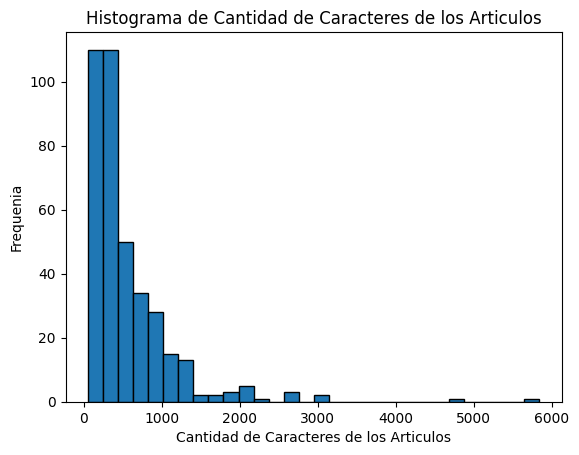

In [24]:
length_aticulo = [len(x["contenido"]) for x in articulos]

import matplotlib.pyplot as plt

plt.hist(length_aticulo, bins=30, edgecolor='black')
plt.title('Histograma de Cantidad de Caracteres de los Articulos')
plt.xlabel('Cantidad de Caracteres de los Articulos')
plt.ylabel('Frequenia')
plt.show()

## Distribucion de palabras

In [25]:
# Análisis de contenido
df['n_palabras'] = df['contenido'].apply(lambda x: len(x.split()))
df['n_caracteres'] = df['contenido'].apply(len)
df['n_oraciones'] = df['contenido'].apply(lambda x: len(re.findall(r'[.!?]', x)))

# Estadísticas descriptivas
print(df[['n_palabras', 'n_caracteres', 'n_oraciones']].describe())

       n_palabras  n_caracteres  n_oraciones
count  380.000000    380.000000   380.000000
mean    85.455263    570.026316     4.326316
std     88.245105    594.622240     6.329463
min     10.000000     60.000000     0.000000
25%     35.000000    231.000000     1.000000
50%     57.500000    381.500000     2.000000
75%    106.750000    723.000000     4.000000
max    840.000000   5836.000000    61.000000


In [26]:
from collections import Counter
import re

# Unir todo el texto
corpus = ' '.join(df['contenido']).lower()
tokens = re.findall(r'\w+', corpus)

total_palabras = len(tokens)
palabras_unicas = set(tokens)
densidad_lexica = len(palabras_unicas) / total_palabras
frecuencia = Counter(tokens)

print(f"Total de palabras: {total_palabras}")
print(f"Palabras únicas: {len(palabras_unicas)}")
print(f"Densidad léxica: {densidad_lexica:.4f}")
print("Palabras más frecuentes:")
print(frecuencia.most_common(20))


Total de palabras: 32701
Palabras únicas: 4768
Densidad léxica: 0.1458
Palabras más frecuentes:
[('de', 2411), ('la', 1752), ('y', 1270), ('el', 1036), ('los', 1035), ('en', 779), ('las', 761), ('a', 628), ('que', 602), ('del', 482), ('por', 417), ('o', 386), ('ley', 357), ('para', 310), ('se', 294), ('con', 282), ('su', 237), ('no', 186), ('al', 170), ('estado', 162)]


In [ ]:
import nltk
from nltk.corpus import stopwords
from collections import Counter
import re

# Descargar las stopwords si no lo has hecho
nltk.download('stopwords')
stopwords_es = set(stopwords.words('spanish'))

# Tokenizar y filtrar
tokens = re.findall(r'\w+', corpus.lower())
tokens_filtrados = [t for t in tokens if t not in stopwords_es and len(t) > 2]

# Análisis
frecuencia = Counter(tokens_filtrados)
print(f"Palabras únicas (sin stopwords): {len(set(tokens_filtrados))}")
print("Top 20 palabras sin stopwords:")
print(frecuencia.most_common(20))


In [ ]:
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

# Descargar stopwords 
nltk.download('stopwords')
stopwords_es = stopwords.words('spanish')

# Crear vectorizador con las stopwords personalizadas
vectorizer = CountVectorizer(stop_words=stopwords_es, ngram_range=(2, 3), min_df=2)

# Ajustar al corpus (lista de contenidos)
corpus = df['contenido'].tolist()
X = vectorizer.fit_transform(corpus)

# Obtener n-gramas y sus frecuencias
frecuencias = X.toarray().sum(axis=0)
ngramas = vectorizer.get_feature_names_out()
resultados = sorted(zip(ngramas, frecuencias), key=lambda x: x[1], reverse=True)

# Mostrar top 20
print("Top 20 n-gramas más frecuentes (sin stopwords):")
for ngrama, freq in resultados[:20]:
    print(f"{ngrama}: {freq}")


Top 20 n-gramas más frecuentes (sin stopwords):
presidente república: 61
entidades territoriales: 30
general nación: 30
podrá ser: 28
corte constitucional: 27
ley podrá: 26
constitución ley: 24
determine ley: 24
establezca ley: 24
corte suprema: 23
suprema justicia: 23
corte suprema justicia: 22
ley determinará: 22
señale ley: 21
partidos movimientos: 19
constitución leyes: 15
ser elegido: 15
servicios públicos: 15
toda persona: 15
fuerza pública: 14


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/coberndorm/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


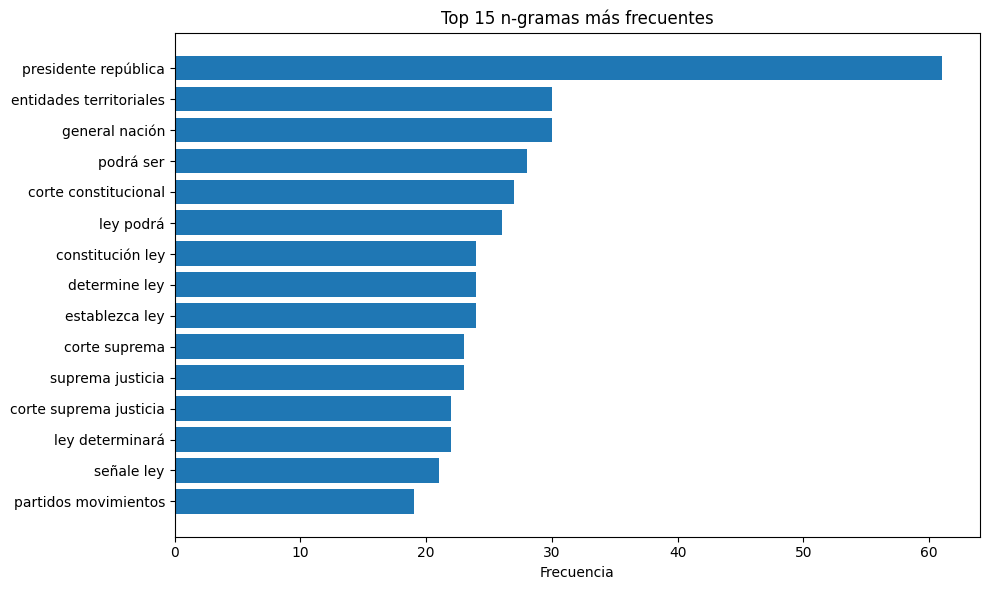

In [ ]:
import matplotlib.pyplot as plt

top_ngrams = resultados[:15]
ng_textos, ng_freqs = zip(*top_ngrams)

plt.figure(figsize=(10, 6))
plt.barh(ng_textos[::-1], ng_freqs[::-1])
plt.title("Top 15 n-gramas más frecuentes")
plt.xlabel("Frecuencia")
plt.tight_layout()
plt.show()

# Clustering semantico de Palabras

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import spacy
import re
from collections import Counter
import umap
import hdbscan
from bertopic import BERTopic
import nltk
from nltk.corpus import stopwords
from sentence_transformers import SentenceTransformer
import plotly.express as px
from wordcloud import WordCloud


/home/coberndorm/Documents/University/Especializacion_en_Desarrollo_de_Software/Aprendizaje_de_Maquina/chatbot-rag-constitucion-col/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def run_bertopic_analysis(texts, language="spanish"):
    """Run BERTopic analysis on the texts"""
    # Load pretrained language model
    embedding_model = SentenceTransformer('distiluse-base-multilingual-cased-v1')
    
    # Create dimensionality reduction model
    umap_model = umap.UMAP(
        n_neighbors=15,
        n_components=5,
        min_dist=0.0,
        metric='cosine',
        random_state=42
    )
    
    # Create clustering model
    hdbscan_model = hdbscan.HDBSCAN(
        min_cluster_size=5,
        metric='euclidean',
        cluster_selection_method='eom',
        prediction_data=True
    )
    
    # Create vectorizer model
    vectorizer_model = CountVectorizer(
        stop_words=stopwords_es,
        min_df=3,
        ngram_range=(1, 2)
    )
    
    # Create and train BERTopic model
    topic_model = BERTopic(
        embedding_model=embedding_model,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        vectorizer_model=vectorizer_model,
        language=language,
        verbose=True
    )
    
    topics, probs = topic_model.fit_transform(texts)
    
    return topic_model, topics, probs

# Run BERTopic
bertopic_model, topics, _ = run_bertopic_analysis(df['contenido'])

# Add topics to dataframe
df['bertopic'] = topics

# Visualize BERTopic results
bertopic_model.visualize_topics().write_html("Figures/bertopic_visualization.html")
bertopic_model.visualize_barchart(top_n_topics=10).write_html("Figures/bertopic_barchart.html")

# Print topic information
for topic_id in set(topics):
    if topic_id != -1:  # Skip outlier topic
        topic_info = bertopic_model.get_topic(topic_id)
        topic_words = [word for word, _ in topic_info]
        print(f"Topic {topic_id}: {', '.join(topic_words[:10])}")


2025-05-02 18:46:03,781 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 12/12 [00:26<00:00,  2.23s/it]
2025-05-02 18:46:30,625 - BERTopic - Embedding - Completed ✓
2025-05-02 18:46:30,626 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-02 18:46:37,886 - BERTopic - Dimensionality - Completed ✓
2025-05-02 18:46:37,888 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-02 18:46:37,917 - BERTopic - Cluster - Completed ✓
2025-05-02 18:46:37,927 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-02 18:46:38,002 - BERTopic - Representation - Completed ✓


Topic 0: municipios, territoriales, recursos, ley, entidades, entidades territoriales, nacional, territorio, plan, participación
Topic 1: general, funciones, nación, general nación, ley, justicia, judicial, consejo, judiciales, fiscal
Topic 2: electoral, elección, ciudadanos, organización, miembros, partidos, diputados, ley, movimientos, elecciones
Topic 3: derecho, familia, garantiza, derechos, persona, libertad, todas, protección, sociedad, libre
Topic 4: colombianos, colombiano, derechos, ser, nacimiento, extranjeros, país, nacional, humanos, derecho
Topic 5: presidente, presidente república, república, vicepresidente, cargo, podrá, siguiente, elegido, senado, falta
Topic 6: social, salud, servicios, seguridad, seguridad social, interés, promoverá, propiedad, ley, legislador
Topic 7: sesiones, congreso, cámaras, reunirá, congresistas, podrán, comisiones, actos, mayoría, presidente
Topic 8: ley determinará, determinará, gestión, ley, relativo, funcionamiento, presten, servicio, ley p

Generating embeddings and creating semantic clusters...


Batches: 100%|██████████| 12/12 [00:25<00:00,  2.13s/it]


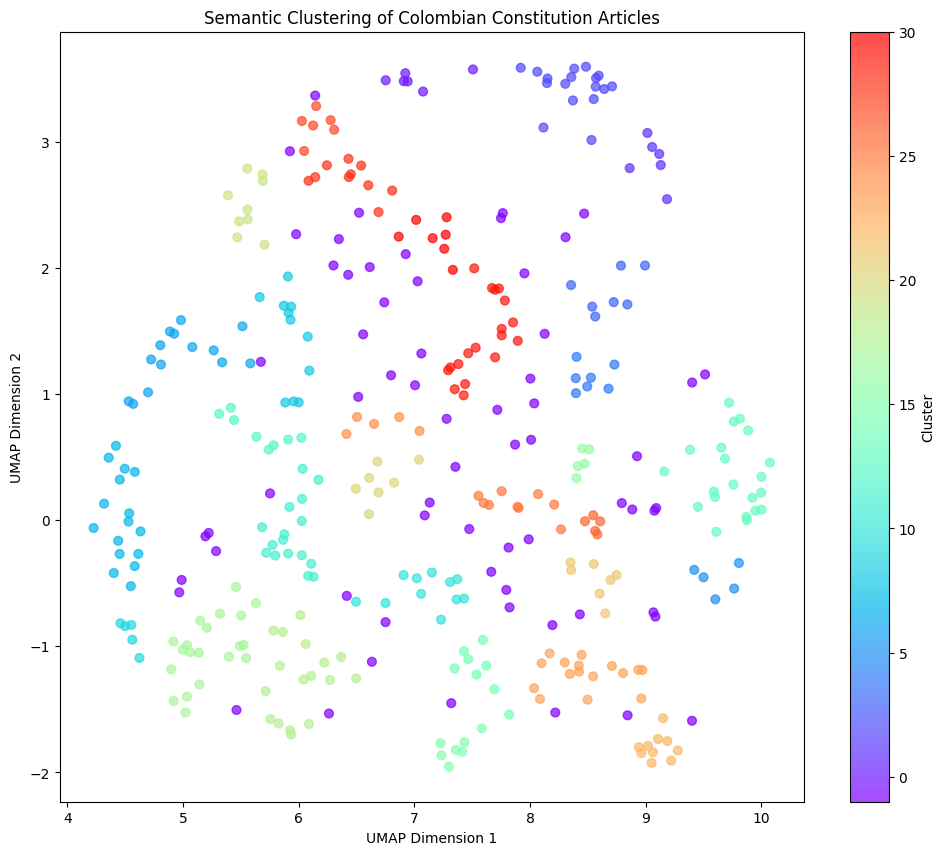

In [ ]:
# ----- SEMANTIC CLUSTERING WITH EMBEDDINGS -----
print("Generating embeddings and creating semantic clusters...")

def generate_embeddings(texts):
    """Generate embeddings for all texts"""
    model = SentenceTransformer('distiluse-base-multilingual-cased-v1')
    embeddings = model.encode(texts, show_progress_bar=True)
    return embeddings

# Generate embeddings
article_embeddings = generate_embeddings(df['contenido'].tolist())

# Save embeddings
np.save('article_embeddings.npy', article_embeddings)

# Apply UMAP for dimensionality reduction
reducer = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.1, metric='cosine', random_state=42)
umap_embeddings = reducer.fit_transform(article_embeddings)

# Create clusters using HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=2, metric='euclidean', gen_min_span_tree=True)
cluster_labels = clusterer.fit_predict(umap_embeddings)

# Add cluster information to dataframe
df['semantic_cluster'] = cluster_labels

# Save results
df.to_csv('constitucion_colombia_con_temas.csv', index=False)

# Visualize clusters
plt.figure(figsize=(12, 10))
scatter = plt.scatter(
    umap_embeddings[:, 0], 
    umap_embeddings[:, 1], 
    c=cluster_labels, 
    cmap='rainbow', 
    alpha=0.7,
    s=40
)
plt.colorbar(scatter, label='Cluster')
plt.title('Semantic Clustering of Colombian Constitution Articles')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.savefig('Figures/semantic_clusters.png')

# Create interactive visualization
hover_text = [
    f"Artículo {row['numero']}<br>" +
    f"Contenido: {row['contenido'][:100]}..."
    for _, row in df.iterrows()
]

# Create Plotly figure
fig = px.scatter(
    x=umap_embeddings[:, 0], 
    y=umap_embeddings[:, 1],
    color=df['semantic_cluster'].astype(str),
    hover_name=df['numero'].astype(str),
    title='Interactive Semantic Clustering of Colombian Constitution Articles',
    labels={'color': 'Cluster'},
    template='plotly_white'
)

fig.update_traces(marker=dict(size=10, opacity=0.7))
fig.write_html('Figures/interactive_semantic_clusters.html')